# Image classification with Vision Transformer

* Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 13.4 MB/s 


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

* Data 다운로드

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169017344/169001437 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


* 시각화

In [5]:
from IPython.display import Image

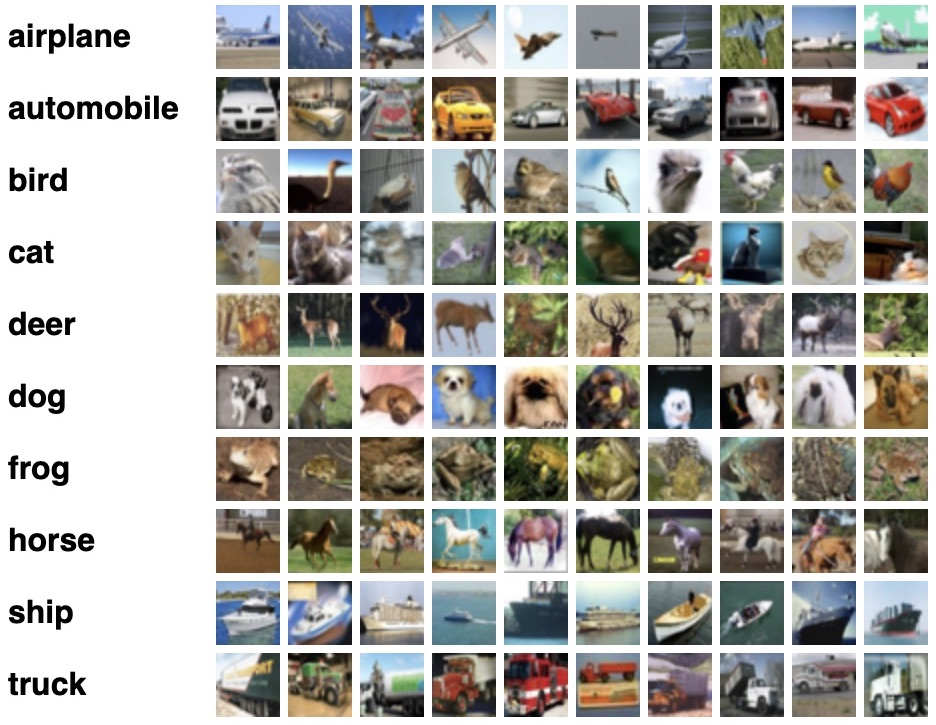

In [6]:
Image('/content/drive/MyDrive/CDS2(2022-2)/RNN_VIT/100.jpg')

In [7]:
# CIFAR-100 클래스
CIFAR100_CLASSES = sorted(['beaver', 'dolphin', 'otter', 'seal', 'whale',  # aquatic mammals
                           'aquarium' 'fish', 'flatfish', 'ray', 'shark', 'trout',  # fish
                           'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', # flowers
                           'bottles', 'bowls', 'cans', 'cups', 'plates', # food containers
                           'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', # fruit and vegetables
                           'clock', 'computer' 'keyboard', 'lamp', 'telephone', 'television', # household electrical devices
                           'bed', 'chair', 'couch', 'table', 'wardrobe', # household furniture
                           'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', # insects
                           'bear', 'leopard', 'lion', 'tiger', 'wolf', # large carnivores
                           'bridge', 'castle', 'house', 'road', 'skyscraper', # large man-made outdoor things
                           'cloud', 'forest', 'mountain', 'plain', 'sea', # large natural outdoor scenes
                           'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', # large omnivores and herbivores
                           'fox', 'porcupine', 'possum', 'raccoon', 'skunk', # medium-sized mammals
                           'crab', 'lobster', 'snail', 'spider', 'worm', # non-insect invertebrates
                           'baby', 'boy', 'girl', 'man', 'woman', # people
                           'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', # reptiles
                           'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', # small mammals
                           'maple', 'oak', 'palm', 'pine', 'willow', # trees
                           'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', # vehicles 1
                           'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor' # vehicles 2
                          ])

In [8]:
import matplotlib.pyplot as plt

In [9]:
x_train[0].shape

(32, 32, 3)

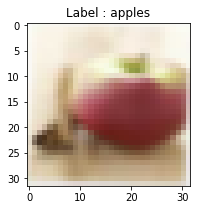

In [10]:
plt.figure(figsize=(3,3))
plt.imshow(x_train[2])
plt.title('Label : {}'.format(CIFAR100_CLASSES[y_train[2][0]]))
plt.show()

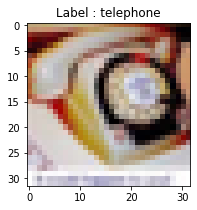

In [11]:
plt.figure(figsize=(3,3))
plt.imshow(x_train[5])
plt.title('Label : {}'.format(CIFAR100_CLASSES[y_train[5][0]]))
plt.show()

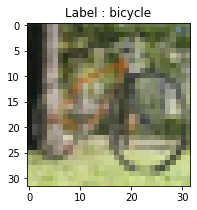

In [12]:
plt.figure(figsize=(3,3))
plt.imshow(x_train[16])
plt.title('Label : {}'.format(CIFAR100_CLASSES[y_train[16][0]]))
plt.show()

* Vision transformer

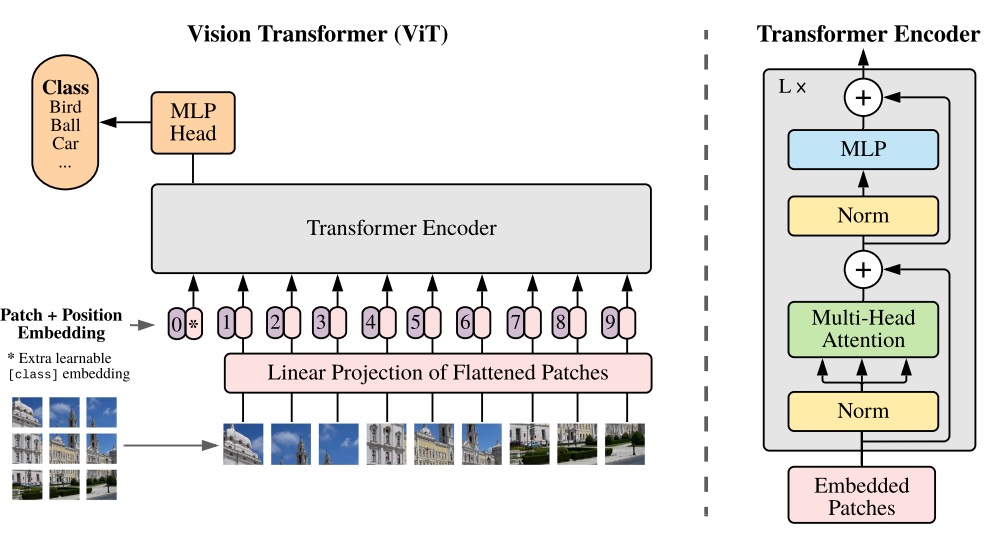

In [13]:
Image('/content/drive/MyDrive/CDS2(2022-2)/RNN_VIT/vit.png')

* hyperparameters

In [14]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 200
# 실험적으로 5번만 진행
image_size = 72  
# 이미지 사이즈 조정
patch_size = 6 
# 이미지를 패치 사이즈로 자를 것이다 1장 → 144장
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
# 트랜스포머 레이어 사이즈
transformer_layers = 8
mlp_head_units = [2048, 1024]  
# 마지막 mlp layer

* Data augmentation

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# 이미지 정규화
# 이미지 사이즈 조정
# 다양한 증강 기법
data_augmentation.layers[0].adapt(x_train)

* Multi Layer Perceptron (Dense Layer)

In [16]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
      # hidden_units을 여러개 두어 하나씩 가져와서 반복하며 여러층을 쌓는다
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        # gelu 사용
        x = layers.Dropout(dropout_rate)(x)
    return x
# 첫 시간에 배웠던 Dense layer

* 패치로 이미지 자르는 Class

In [17]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        # 이미지를 자를 크기

    def call(self, images):
        batch_size = tf.shape(images)[0]
        # 이미지의 한면이 batch_size
        patches = tf.image.extract_patches(
            images=images,
            # 입력 이미지
            sizes=[1, self.patch_size, self.patch_size, 1],
            # window_size, window_size
            strides=[1, self.patch_size, self.patch_size, 1],
            # stride_size, stride_size
            rates=[1, 1, 1, 1],
            # 가져올 픽셀의 row, col 간격
            padding="VALID",
            # 유효한 영역만 출력
        )
        # 이미지를 패치사이즈로 자르는 코드
        patch_dims = patches.shape[-1]
        # 패치 갯수
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        # 패치를 batch_size, 알아서 맞추기, patch_dims으로 재조정
        return patches

In [18]:
n = 10

In [19]:
images = [[[[x * n + y + 1] for y in range(n)] for x in range(n)]]

In [20]:
images

[[[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]],
  [[11], [12], [13], [14], [15], [16], [17], [18], [19], [20]],
  [[21], [22], [23], [24], [25], [26], [27], [28], [29], [30]],
  [[31], [32], [33], [34], [35], [36], [37], [38], [39], [40]],
  [[41], [42], [43], [44], [45], [46], [47], [48], [49], [50]],
  [[51], [52], [53], [54], [55], [56], [57], [58], [59], [60]],
  [[61], [62], [63], [64], [65], [66], [67], [68], [69], [70]],
  [[71], [72], [73], [74], [75], [76], [77], [78], [79], [80]],
  [[81], [82], [83], [84], [85], [86], [87], [88], [89], [90]],
  [[91], [92], [93], [94], [95], [96], [97], [98], [99], [100]]]]

In [21]:
tf.image.extract_patches(images=images,
                           sizes=[1, 3, 3, 1],
                           strides=[1, 3, 3, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

<tf.Tensor: shape=(1, 3, 3, 9), dtype=int32, numpy=
array([[[[ 1,  2,  3, 11, 12, 13, 21, 22, 23],
         [ 4,  5,  6, 14, 15, 16, 24, 25, 26],
         [ 7,  8,  9, 17, 18, 19, 27, 28, 29]],

        [[31, 32, 33, 41, 42, 43, 51, 52, 53],
         [34, 35, 36, 44, 45, 46, 54, 55, 56],
         [37, 38, 39, 47, 48, 49, 57, 58, 59]],

        [[61, 62, 63, 71, 72, 73, 81, 82, 83],
         [64, 65, 66, 74, 75, 76, 84, 85, 86],
         [67, 68, 69, 77, 78, 79, 87, 88, 89]]]], dtype=int32)>

In [22]:
images

[[[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]],
  [[11], [12], [13], [14], [15], [16], [17], [18], [19], [20]],
  [[21], [22], [23], [24], [25], [26], [27], [28], [29], [30]],
  [[31], [32], [33], [34], [35], [36], [37], [38], [39], [40]],
  [[41], [42], [43], [44], [45], [46], [47], [48], [49], [50]],
  [[51], [52], [53], [54], [55], [56], [57], [58], [59], [60]],
  [[61], [62], [63], [64], [65], [66], [67], [68], [69], [70]],
  [[71], [72], [73], [74], [75], [76], [77], [78], [79], [80]],
  [[81], [82], [83], [84], [85], [86], [87], [88], [89], [90]],
  [[91], [92], [93], [94], [95], [96], [97], [98], [99], [100]]]]

In [23]:
tf.image.extract_patches(images=images,
                           sizes=[1, 3, 3, 1],
                           strides=[1, 3, 3, 1],
                           rates=[1, 2, 2, 1],
                           padding='VALID')

<tf.Tensor: shape=(1, 2, 2, 9), dtype=int32, numpy=
array([[[[ 1,  3,  5, 21, 23, 25, 41, 43, 45],
         [ 4,  6,  8, 24, 26, 28, 44, 46, 48]],

        [[31, 33, 35, 51, 53, 55, 71, 73, 75],
         [34, 36, 38, 54, 56, 58, 74, 76, 78]]]], dtype=int32)>

* 이미지를 패치로 잘라서 시각화

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108
(1, 144, 108)


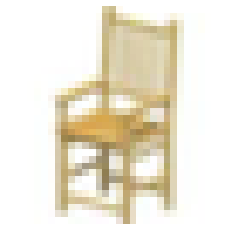

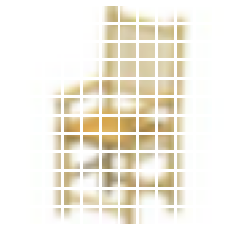

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")
# 원본 이미지 랜덤하게 한장 시각화

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
# 이미지 사이즈 조정

patches = Patches(patch_size)(resized_image)
# 이미지 패치로 자르기
print(f"Image size: {image_size} X {image_size}")
# 이미지 사이즈
print(f"Patch size: {patch_size} X {patch_size}")
# 패치 크기
print(f"Patches per image: {patches.shape[1]}")
# 패치로 나눈 이미지 갯수
print(f"Elements per patch: {patches.shape[-1]}")
# 
print(patches.shape)


n = int(np.sqrt(patches.shape[1]))
# 패치로 자른 전체 이미지의 갯수의 제곱근

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
  # 144번 반복
    ax = plt.subplot(n, n, i + 1)
    # 축 지정
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    # 이미지로 사이즈 변환
    plt.imshow(patch_img.numpy().astype("uint8"))
    # 시각화
    plt.axis("off")

In [26]:
(72 / 6) * (72 / 6)

144.0

→ 1장의 Image를 144장의 Patch로 나눈다.

* patch encoding layer

In [27]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        # 패치 갯수
        self.projection = layers.Dense(units=projection_dim)
        # Dense layer : 입력 dim으로 projection
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        # 패치 갯수를 입력하여 projection_dim으로 임베딩(순서학습)
        # ex) [3, 4, 4, 5, 6, 7] -> 2-임베딩 -> [0.23, 0.42]
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # 0부터 패치 갯수까지 1개씩 
        encoded = self.projection(patch) + self.position_embedding(positions)
        # 각 패치를 dense layer를 통과시킨후 position을 더해준다
        # dense layer 임베딩, 순서 정보 임베딩 합치기
        return encoded

* VIT

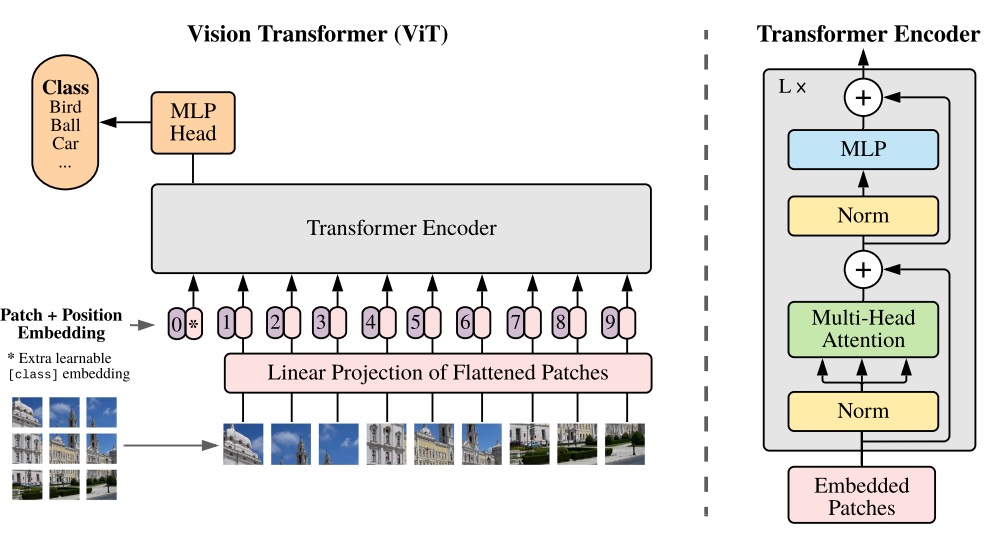

In [28]:
Image('/content/drive/MyDrive/CDS2(2022-2)/RNN_VIT/vit.png')

In [30]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # input 지정
    augmented = data_augmentation(inputs)
    # 데이터 증강
    patches = Patches(patch_size)(augmented)
    # 패치로 자르기
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    # 패치를 dense 통과한 값과 position 더해주기
    
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        #### Create a multi-head attention layer ####
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])
        # Skip connection 1.

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # Layer normalization 2.

        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # MLP        

        encoded_patches = layers.Add()([x3, x2])
        # Skip connection 2

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Compile, train, and evaluate the mode

In [31]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # label 예측
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            # 5개중에 있는지
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

* 실험적으로 5회만 학습 : 학습시간이 오래 걸림.

In [32]:
num_epochs = 5

In [33]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/5
176/176 [==============================] - 78s 373ms/step - loss: 4.4675 - accuracy: 0.0475 - top-5-accuracy: 0.1677 - val_loss: 3.8863 - val_accuracy: 0.1066 - val_top-5-accuracy: 0.3166
Epoch 2/5
176/176 [==============================] - 65s 371ms/step - loss: 3.9544 - accuracy: 0.0940 - top-5-accuracy: 0.2877 - val_loss: 3.6270 - val_accuracy: 0.1578 - val_top-5-accuracy: 0.4052
Epoch 3/5
176/176 [==============================] - 66s 375ms/step - loss: 3.6967 - accuracy: 0.1329 - top-5-accuracy: 0.3651 - val_loss: 3.4324 - val_accuracy: 0.1982 - val_top-5-accuracy: 0.4802
Epoch 4/5
176/176 [==============================] - 66s 377ms/step - loss: 3.5257 - accuracy: 0.1582 - top-5-accuracy: 0.4158 - val_loss: 3.1761 - val_accuracy: 0.2294 - val_top-5-accuracy: 0.5096
Epoch 5/5
313/313 [==============================] - 7s 22ms/step - loss: 3.0745 - accuracy: 0.2547 - top-5-accuracy: 0.5418
Test accuracy: 25.47%
Test top 5 accuracy: 54.18%


* 5-epoch만 학습하였기에 제대로 출력이 안됨.

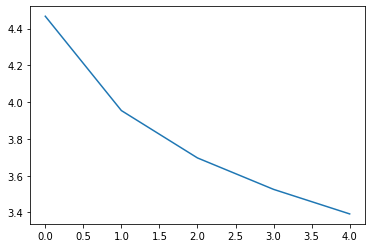

In [34]:
plt.plot(history.history['loss'])

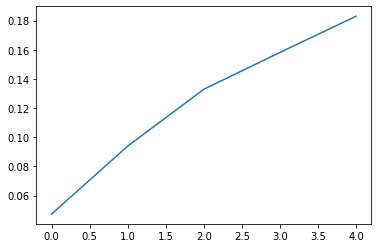

In [35]:
plt.plot(history.history['accuracy'])

* 사전에 100-epoch를 훈련하여 저장된 가중치로 모델 정의

In [36]:
vit_classifier = create_vit_classifier()

In [37]:
vit_classifier.load_weights('/content/drive/MyDrive/CDS2(2022-2)/DA_data/VIT_weights/weights.h5')

In [38]:
num_epochs = 1

In [39]:
history = run_experiment(vit_classifier)

313/313 [==============================] - 7s 22ms/step - loss: 1.8501 - accuracy: 0.5450 - top-5-accuracy: 0.8137
Test accuracy: 54.5%
Test top 5 accuracy: 81.37%
